In [3]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys

sys.path.append("/Net/Groups/BSI/work_scratch/ppapastefanou/src/QPy")


In [4]:
rtobspath = '/Net/Groups/BSI/work_scratch/ppapastefanou/data/Fluxnet_detail/eval_processed'
df22fnet = pd.read_csv(os.path.join(rtobspath, "Fluxnet2000_2021_eval.csv"),  index_col=0, parse_dates=True)
df22fnet['LE'] = - df22fnet['LE']
df24fnet = pd.read_csv(os.path.join(rtobspath, "Fluxnet2023_2024_eval.csv"),  index_col=0, parse_dates=True)
df24fnet['LE'] = - df24fnet['LE']

df_psi_stem_obs = pd.read_csv(os.path.join(rtobspath, "PsiStem2023.csv"),  index_col=0, parse_dates=True)
df_sap_flow_obs = pd.read_csv(os.path.join(rtobspath, "Sapflow2023.csv"),  index_col=0, parse_dates=True)
df_sap_flow_obs.loc[df_sap_flow_obs['J0.5'] < 0.0, 'J0.5'] = 0.0

In [65]:
df_sap_flow_obs

,J0.1,J0.25,J0.5,J0.75,J0.9
date,,,,,
2023-05-01 22:00:00,-1.953358,0.182093,2.507303,3.202199,4.340077
2023-05-01 22:30:00,-2.044817,0.263381,1.999431,3.005463,3.961681
2023-05-01 23:00:00,-1.993363,0.157446,1.737801,2.558568,3.460054
2023-05-01 23:30:00,-1.823605,0.202846,1.799361,2.574223,3.387077
2023-05-02 00:00:00,-1.794785,0.172579,1.707021,2.521190,3.201836
...,...,...,...,...,...
2023-11-05 12:30:00,-6.002791,-3.859052,0.000000,-1.219486,6.302652
2023-11-05 13:00:00,-5.760715,-3.632049,0.000000,-1.385264,6.107093
2023-11-05 13:30:00,-5.694127,-3.465580,0.000000,-1.445547,6.013385


In [ ]:

from src.postprocessing.qnc_defintions import Time_Reduction_Type
from src.postprocessing.qnc_output_parser import QNC_output_parser
from src.postprocessing.qnc_ncdf_reader import QNC_ncdf_reader
from src.postprocessing.qnc_rescaler import QNC_Rescaler
from src.postprocessing.qnc_obs_reader import QNC_obs_reader
    
OUTPUT_DIR = '/Net/Groups/BSI/scratch/ppapastefanou/simulations/QPy/11_transient_latin_hypercube_with_std_HAINICH_data'
OUTPUT_DIR = '/Net/Groups/BSI/scratch/ppapastefanou/simulations/QPy/15_transient_latin_hypercube_with_std_HAINICH_data_full_2024'
post_dir = os.path.join(OUTPUT_DIR, 'post')
os.makedirs(post_dir, exist_ok=True)

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())       

def calc_rmse(df_slice_mod, var_mod, df_slice_obs, var_obs, normalized = False):
    dfm = pd.merge(df_slice_mod[var_mod], df_slice_obs[var_obs], left_index=True, right_index=True, how='inner')
    
    if normalized:
        dfm[var_mod] = dfm[var_mod]/np.max(dfm[var_mod])
        dfm[var_obs] = dfm[var_obs]/np.max(dfm[var_obs])
        
    return rmse(dfm[var_mod], dfm[var_obs])

nsims = 0
for item in os.listdir(os.path.join(OUTPUT_DIR, "output")):
    item_path = os.path.join(OUTPUT_DIR, "output", item)
    if os.path.isdir(item_path):
        nsims += 1

In [67]:
df_rmse = pd.DataFrame(columns= ['fid', 'rmse_psi_stem', 'rmse_psi_stem_norm', 'rmse_gpp_22', 'rmse_gpp_24', 'rmse_le_22', 'rmse_le_24', 'rmse_sapflow_norm'])
fids = np.arange(0,nsims)

for fid in fids:
    parser = QNC_output_parser(os.path.join(OUTPUT_DIR, 'output', str(fid)))
    parser.Read()
    output = parser.Available_outputs['fluxnetdata']
    nc_out_reader = QNC_ncdf_reader(os.path.join(OUTPUT_DIR, 'output', str(fid)),
                                            output.Categories,
                                            output.Identifier,
                                            output.Time_resolution
                                            )
    nc_out_reader.Parse_env_and_variables()

    cat = 'Q_ASSIMI'
    var_mod = 'gpp_avg'
    df_gpp = nc_out_reader.Read_1D_flat(cat, var_mod)
    df_gpp.set_index('date', inplace=True)
    df_gpp.drop('index', axis = 1, inplace=True)

    cat = 'SPQ'
    var_mod = 'qle_avg'
    df_le = nc_out_reader.Read_1D_flat(cat, var_mod)
    df_le.set_index('date', inplace=True)
    df_le.drop('index', axis = 1, inplace=True)

    cat = 'PHYD'
    var_mod = 'psi_stem_avg'
    df_psi_stem_mod = nc_out_reader.Read_1D_flat(cat, var_mod)
    df_psi_stem_mod.set_index('date', inplace=True)
    df_psi_stem_mod.drop('index', axis = 1, inplace=True)

    cat = 'PHYD'
    var_mod = 'G_avg'
    df_G_mod = nc_out_reader.Read_1D_flat(cat, var_mod)
    df_G_mod.set_index('date', inplace=True)
    df_G_mod.drop('index', axis = 1, inplace=True)
    
    nc_out_reader.Close()


    rmse_psi_stem = calc_rmse(df_psi_stem_mod,'psi_stem_avg', df_psi_stem_obs, "FAG")
    rmse_psi_stem_norm = calc_rmse(df_psi_stem_mod,'psi_stem_avg', df_psi_stem_obs, "FAG", normalized=True)
    rmse_gpp_22 = calc_rmse(df_gpp, 'gpp_avg', df22fnet, 'GPP')
    rmse_gpp_24 = calc_rmse(df_gpp, 'gpp_avg', df24fnet, 'GPP')
    rmse_le_22  = calc_rmse(df_le, 'qle_avg', df22fnet, 'LE')
    rmse_le_24  = calc_rmse(df_le, 'qle_avg', df24fnet, 'LE')
    rmse_sapflow_norm = calc_rmse(df_G_mod,'G_avg', df_sap_flow_obs, "J0.5", normalized=True)

    df_rmse.loc[len(df_rmse)] = [fid, rmse_psi_stem, rmse_psi_stem_norm, rmse_gpp_22, rmse_gpp_24, rmse_le_22, rmse_le_24, rmse_sapflow_norm]
    
    print(f"Completed {fid} out of {nsims}.")

df_rmse.to_csv(os.path.join(post_dir, "standard_ranking.csv"), index= False)

     Reading time variable...      Done! (0.0 sec.)
     Parsing time variable... Done! (1.8 sec.)
     Reading variable names and units... Done! (1.8 sec.)
Reading 1D variable... Done! (0.0 sec.)
Reading 1D variable... Done! (0.0 sec.)
Reading 1D variable... Done! (0.0 sec.)
Reading 1D variable... Done! (0.0 sec.)
     Reading time variable...      Done! (0.0 sec.)
     Parsing time variable... Done! (1.7 sec.)
     Reading variable names and units... Done! (1.7 sec.)
Reading 1D variable... Done! (0.0 sec.)
Reading 1D variable... Done! (0.0 sec.)
Reading 1D variable... Done! (0.0 sec.)
Reading 1D variable... Done! (0.0 sec.)
     Reading time variable...      Done! (0.0 sec.)
     Parsing time variable... Done! (1.8 sec.)
     Reading variable names and units... Done! (1.8 sec.)
Reading 1D variable... Done! (0.0 sec.)
Reading 1D variable... Done! (0.0 sec.)
Reading 1D variable... Done! (0.0 sec.)
Reading 1D variable... Done! (0.0 sec.)
     Reading time variable...      Done! (0.0 sec

In [58]:
df_rmse

,fid,rmse_psi_stem,rmse_gpp_22,rmse_gpp_24,rmse_le_22,rmse_le_24,rmse_sapflow_norm
0,0.0,0.353956,3.635982,3.278169,43.883223,46.947214,NaN
1,1.0,0.324032,3.824660,3.360684,46.985784,51.112348,0.238991
2,2.0,0.318903,3.613942,3.285719,40.745431,40.922718,0.238904


In [55]:
df_rmse

,fid,rmse_psi_stem,rmse_gpp_22,rmse_gpp_24,rmse_le_22,rmse_le_24,rmse_sapflow_norm
0,1.0,0.324032,3.82466,3.360684,46.985784,51.112348,0.238991


KeyError: 'G_avg'

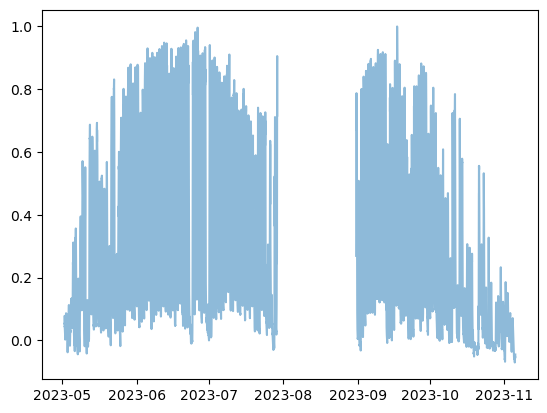

In [31]:
plt.plot(df_sap_flow_obs['J0.5'], alpha = 0.5)
plt.plot(df_psi_stem_mod['G_avg'], alpha = 0.5)
plt.xlim(pd.to_datetime('2023-05-01 00:00:00'), pd.to_datetime('2023-11-01'))

In [118]:
df_psi_stem_mod['stem_flow_avg']

date
2000-01-01 00:00:00    2.714348e-10
2000-01-01 00:30:00    2.714348e-10
2000-01-01 01:00:00    2.714348e-10
2000-01-01 01:30:00    2.714348e-10
2000-01-01 02:00:00    2.714348e-10
                           ...     
2024-12-31 21:30:00    1.165234e-10
2024-12-31 22:00:00    1.165234e-10
2024-12-31 22:30:00    1.165234e-10
2024-12-31 23:00:00    1.165234e-10
2024-12-31 23:30:00    1.165234e-10
Name: stem_flow_avg, Length: 438000, dtype: float32

In [32]:
calc_rmse(df_psi_stem_mod,'psi_stem_avg', df_psi_stem_obs, "FAG")

0.3240321041377402

In [ ]:
calc_rmse(df_gpp, 'gpp_avg', df24fnet, 'GPP')

3.2781690291904946

In [ ]:
calc_rmse(df_gpp, 'gpp_avg', df22fnet, 'GPP')

3.635981741954122

In [69]:
calc_rmse(df_le, 'qle_avg', df22fnet, 'LE')

43.88322284839233

In [73]:
calc_rmse(df_le, 'qle_avg', df24fnet, 'LE')

46.94721363732314

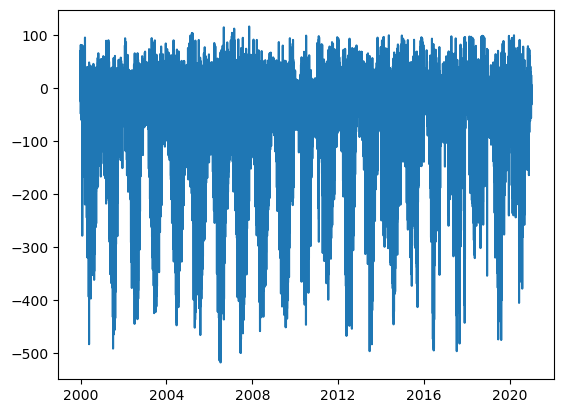

In [72]:
plt.plot(df22fnet['LE'])